In [45]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dmia-production-ml-2021-1-passwords/sample_submission.csv/sample_submission.csv
/kaggle/input/dmia-production-ml-2021-1-passwords/Xtest.csv/Xtest.csv
/kaggle/input/dmia-production-ml-2021-1-passwords/train.csv/train.csv


In [46]:
import pandas as pd
import numpy as np

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import re
import pickle

import math
import sys
import os

### Data Exploration

In [47]:
train = pd.read_csv('/kaggle/input/dmia-production-ml-2021-1-passwords/train.csv/train.csv')
test = pd.read_csv('/kaggle/input/dmia-production-ml-2021-1-passwords/Xtest.csv/Xtest.csv')
train.dropna(inplace=True)

In [48]:
y = train.Times
train.drop(columns='Times', inplace=True)
test.drop(columns='Id', inplace=True)

Let's generate some features:

- password length
- digits count
- letters count
- special symbols count
- unique symbols count
- uppercase symbols count
- lowercase symbols count

In [49]:
def count_digits(password):
    return sum((c.isdigit() for c in password))

def count_letters(password):
    return sum((c.isalpha() for c in password))

def count_special(password):
    return sum((1 for c in password if not (c.isalpha() or c.isdigit())))

def count_unique(password):
    ps = set(password)
    return len(ps)

def count_uppercase(password):
    return sum((c.isupper() for c in password))

def count_lowercase(password):
    return sum((c.islower() for c in password))

In [50]:
def preprocess_data(df):
    df['len'] = df['Password'].str.len()
    df['Password'] = df['Password'].apply(lambda x: str(x))
    df['n_lowercase'] = df['Password'].apply(lambda x: count_lowercase(x))
    df['n_digits'] = df['Password'].apply(lambda x: count_digits(x))
    df['n_letters'] = df['Password'].apply(lambda x: count_letters(x))
    df['n_special'] = df['Password'].apply(lambda x: count_special(x))
    df['n_unique'] = df['Password'].apply(lambda x: count_unique(x))
    df['n_uppercase'] = df['Password'].apply(lambda x: count_uppercase(x))
    df['n_lowercase'] = df['Password'].apply(lambda x: count_lowercase(x))
    return df

In [51]:
#train1 = preprocess_data(df)
#test1 = preprocess_data(test)

In [52]:
df = train.append(test)

In [53]:
df['Password'] = df.Password.apply(lambda x: ' '.join(re.findall('\S', str(x))))  

**LSTM**

In [54]:
from keras.models import Sequential
from keras.layers import Dense,  Activation, LSTM, Embedding, Dropout, Concatenate, Input, ReLU
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences 
import tensorflow as tf
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam

In [55]:
tokenizer = Tokenizer(100, filters='', lower=False)
tokenizer.fit_on_texts(df['Password'])
tokens = tokenizer.texts_to_sequences(df['Password'])

In [56]:
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [57]:
df['len'] = df['Password'].str.len()
df_tokenized = pad_sequences(tokens, df['len'].max(), padding='post')
print(df_tokenized.shape)

(5189369, 83)


**Train-test split**

In [58]:
from sklearn.model_selection import train_test_split

X = df_tokenized[:train.shape[0]]      #train part
X_test = df_tokenized[train.shape[0]:] #test part


X_train, X_val, y_train, y_val = train_test_split(X, y, 
                                                  test_size=0.1, 
                                                  train_size=0.9, 
                                                  random_state=87)

print('X_train:', X_train.shape)
print('y_train:', y_train.shape, end='\n\n')

print('X_val:', X_val.shape)
print('y_val:', y_val.shape, end='\n\n')

print('X_test:', X_test.shape)

X_train: (3736344, 83)
y_train: (3736344,)

X_val: (415150, 83)
y_val: (415150,)

X_test: (1037875, 83)


**Model**

In [59]:
def rmsle(y_true, y_pred):
    """Loss function"""
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    return tf.math.sqrt(
        tf.reduce_mean(
            tf.math.squared_difference(tf.math.log1p(y_pred), tf.math.log1p(y_true))
        )
    )

In [60]:
EMBEDDING_VECTOR_LENGHT = 16
HIDDEN_DIM = 16

early_stopping = EarlyStopping(monitor='val_loss', patience=2, verbose=0, mode='auto')

model = Sequential()
model.add(Embedding(100, 
                    EMBEDDING_VECTOR_LENGHT, 
                    input_length= df['len'].max(),
                    mask_zero=True,))

model.add(LSTM(HIDDEN_DIM))
model.add(Dense(1))
model.add(ReLU())

opt = Adam()
model.compile(loss=rmsle,
              optimizer=opt)
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 83, 16)            1600      
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                2112      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
_________________________________________________________________
re_lu_1 (ReLU)               (None, 1)                 0         
Total params: 3,729
Trainable params: 3,729
Non-trainable params: 0
_________________________________________________________________
None


In [61]:
hist = model.fit(
    X_train, y_train, 
    epochs=8, 
    batch_size=512,
    validation_data=(X_val, y_val), 
    callbacks=[early_stopping])

Epoch 1/8
7298/7298 [==============================] - 624s 85ms/step - loss: 0.4014 - val_loss: 0.3592
Epoch 2/8
7298/7298 [==============================] - 620s 85ms/step - loss: 0.3559 - val_loss: 0.3480
Epoch 3/8
7298/7298 [==============================] - 620s 85ms/step - loss: 0.3480 - val_loss: 0.3452
Epoch 4/8
7298/7298 [==============================] - 619s 85ms/step - loss: 0.3436 - val_loss: 0.3429
Epoch 5/8
7298/7298 [==============================] - 630s 86ms/step - loss: 0.3430 - val_loss: 0.3422
Epoch 6/8
7298/7298 [==============================] - 628s 86ms/step - loss: 0.3425 - val_loss: 0.3414
Epoch 7/8
7298/7298 [==============================] - 634s 87ms/step - loss: 0.3429 - val_loss: 0.3402
Epoch 8/8
7298/7298 [==============================] - 633s 87ms/step - loss: 0.3407 - val_loss: 0.3400


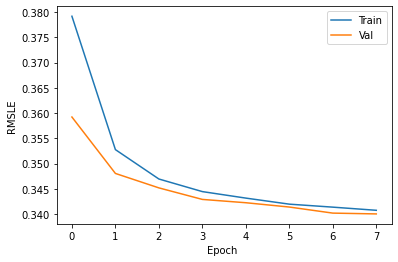

In [62]:
plt.plot(hist.history['loss'], label = 'Train');
plt.plot(hist.history['val_loss'], label ='Val');
plt.legend();
plt.xlabel('Epoch ');
plt.ylabel('RMSLE');

In [63]:
model.save('lstm_model') 

In [64]:
#from keras.models import load_model
#model = load_model('lstm_model', custom_objects={'rmsle':rmsle})

**Prediction**

In [65]:
y_pred = model.predict(X_test, batch_size=1024)

In [66]:
res = pd.read_csv('/kaggle/input/dmia-production-ml-2021-1-passwords/sample_submission.csv/sample_submission.csv')
res['Times'] = y_pred
res.to_csv('res6.csv', index=False)